In [41]:
from socceraction.data.wyscout import PublicWyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions as convert_to_actions_wyscout
from socceraction.spadl.statsbomb import convert_to_actions as convert_to_actions_statsbomb
from socceraction.data.opta import OptaLoader
from socceraction.data.statsbomb import StatsBombLoader
from socceraction.spadl.config import actiontypes, bodyparts
import socceraction.spadl as spadl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, brier_score_loss, log_loss, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier
import math
import pickle
import os
from name_matching.name_matcher import NameMatcher
from rapidfuzz import fuzz
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import r_regression, SelectKBest, chi2, mutual_info_classif, SequentialFeatureSelector, RFECV, SelectFromModel, mutual_info_regression, f_regression
from scipy.stats import pearsonr, chisquare
from mrmr import mrmr_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVR, SVC
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.cluster import DBSCAN

In [42]:
# CONFIG FOR EXPERIMENTS SCENARIO
USE_EVALUATION_METRIC_CLASSIFICATION = True
INCLUDE_SKILL_PLAYERS_OPTIONS = [
    False,
    # True
]
SAMPLING_OPTIONS = [
    # "none",
    "random_oversampled",
    "random_undersampled",
    "smote_oversampled"
]
FEATURE_SELECTION_OPTIONS = [
    "pearson",
    "chisquare",
    "mutualinf",
    "mrmr",
    "rfembedded",
    "lasso"
]
RANDOM_STATE_OPTIONS = [0, 42]
FEATURE_SELECTION_OPTIONS_FOR_PLAYER_PROBS = [
    "pearson",
    "mutualinf"
]
if USE_EVALUATION_METRIC_CLASSIFICATION:
    MODEL_ALGORITHM_OPTIONS = [
        "xgbclassifier",
        # "catboostclassifier",
        # "rfclassifier"
    ]
else:
    MODEL_ALGORITHM_OPTIONS = [
        "xgbregressor",
        # "rfregressor",
        # "logregression"
    ]
CONFIG_EXPERIMENTS_SCENARIO_MAP = {}
CONFIG_EXPERIMENTS_SKILL_PROBS_SCENARIO_MAP = {}

def construct_config_experiments_scenario_map():
    index_counter = 1
    for include_skill_opt in INCLUDE_SKILL_PLAYERS_OPTIONS:
        for random_state_opt in RANDOM_STATE_OPTIONS:
            for sampling_opt in SAMPLING_OPTIONS:
                if (include_skill_opt == False):
                    for algorithm_opt in MODEL_ALGORITHM_OPTIONS:
                        CONFIG_EXPERIMENTS_SCENARIO_MAP[index_counter] = \
                            {"include_skill_opt" : 1 if include_skill_opt else 0, \
                            "sampling_opt" : sampling_opt, \
                            "feature_selection_opt" : "none", \
                            "algorithm_opt" : algorithm_opt, \
                            "random_state_opt": random_state_opt}
                        index_counter += 1
                else:
                    for feature_selection_opt in FEATURE_SELECTION_OPTIONS:
                        for algorithm_opt in MODEL_ALGORITHM_OPTIONS:
                            CONFIG_EXPERIMENTS_SCENARIO_MAP[index_counter] = \
                                {"include_skill_opt" : 1 if include_skill_opt else 0, \
                                "sampling_opt" : sampling_opt, \
                                "feature_selection_opt" : feature_selection_opt, \
                                "algorithm_opt" : algorithm_opt, \
                                "random_state_opt": random_state_opt}
                            index_counter += 1

def construct_config_experiments_skill_probs_scenario_map():
    index_counter = 1
    for feature_selection_opt in FEATURE_SELECTION_OPTIONS_FOR_PLAYER_PROBS:
        CONFIG_EXPERIMENTS_SKILL_PROBS_SCENARIO_MAP[index_counter] = {
            "random_state_opt" : "none",
            "feature_selection_opt" : feature_selection_opt
        }
        index_counter += 1

construct_config_experiments_scenario_map()
construct_config_experiments_skill_probs_scenario_map()

In [43]:
# COLUMNS FOR TEST EXPERIMENT RESULT
COLUMNS_EVALUATION_METRIC_CLASSIFICATION = [
    "rec_score",
    "prec_score",
    "F1_score",
    "acc_score",
    "auc_score",
    "mcc_score",
    "brier_score",
    "log_loss_score",
    "balanced_acc_score"
]
COLUMNS_EVALUATION_METRIC_REGRESSION = [
    "mean_squared_error_score",
    "root_mean_squared_error_score",
    "auc_score",
    "brier_score",
    "log_loss_score",
    "mean_absolute_error_score",
    "r_squared_score",
    "mean_absolute_percentage_error_score"
]
COLUMNS_SCENARIO_NAME = [
    "include_skill_opt",
    "sampling_opt",
    "feature_selection_opt",
    "algorithm_opt",
    "random_state_opt"
]
# if (USE_EVALUATION_METRIC_CLASSIFICATION):
#     COLUMNS_EXPERIMENT_RESULT = ["case_number"] + COLUMNS_SCENARIO_NAME + COLUMNS_EVALUATION_METRIC_CLASSIFICATION
# else:
#     COLUMNS_EXPERIMENT_RESULT = ["case_number"] + COLUMNS_SCENARIO_NAME + COLUMNS_EVALUATION_METRIC_REGRESSION

COLUMNS_EXPERIMENT_RESULT = ["case_number"] + COLUMNS_SCENARIO_NAME

COLUMNS_EXPERIMENT_RESULT_PLAYER_SKILL_PROBS = [
    "case_number",
    "feature_selection_opt",
    "random_selection_opt",
    # "mean_squared_error_score",
    # "root_mean_squared_error_score",
    # "mean_absolute_error_score",
    # "r_squared_score",
    # "mean_absolute_percentage_error_score"
]

In [44]:
api_wyscout = PublicWyscoutLoader(root="data/wyscout")
api_opta = OptaLoader(root="data/opta")
api_statsbomb = StatsBombLoader(root="data/statsbomb", getter="local")

In [45]:
for idx, action_name in enumerate(actiontypes):
    print(f'action_id : {idx}   action_name : {action_name}')

action_id : 0   action_name : pass
action_id : 1   action_name : cross
action_id : 2   action_name : throw_in
action_id : 3   action_name : freekick_crossed
action_id : 4   action_name : freekick_short
action_id : 5   action_name : corner_crossed
action_id : 6   action_name : corner_short
action_id : 7   action_name : take_on
action_id : 8   action_name : foul
action_id : 9   action_name : tackle
action_id : 10   action_name : interception
action_id : 11   action_name : shot
action_id : 12   action_name : shot_penalty
action_id : 13   action_name : shot_freekick
action_id : 14   action_name : keeper_save
action_id : 15   action_name : keeper_claim
action_id : 16   action_name : keeper_punch
action_id : 17   action_name : keeper_pick_up
action_id : 18   action_name : clearance
action_id : 19   action_name : bad_touch
action_id : 20   action_name : non_action
action_id : 21   action_name : dribble
action_id : 22   action_name : goalkick


In [46]:
for idx, bodypart_name in enumerate(bodyparts):
    print(f'bodypart_id : {idx}   bodypart_name : {bodypart_name}')

bodypart_id : 0   bodypart_name : foot
bodypart_id : 1   bodypart_name : head
bodypart_id : 2   bodypart_name : other
bodypart_id : 3   bodypart_name : head/other
bodypart_id : 4   bodypart_name : foot_left
bodypart_id : 5   bodypart_name : foot_right


In [47]:
def convert_events_df_to_spadl(events_df, home_team_id, source):
    if (source == "Statsbomb"):
        spadl_events_df = convert_to_actions_statsbomb(events_df, home_team_id)
    else:
        spadl_events_df = convert_to_actions_wyscout(events_df, home_team_id)
    spadl_events_df['time_seconds'] = spadl_events_df['time_seconds'].astype('float64')
    spadl_events_df['timestamp'] = pd.to_datetime(spadl_events_df['time_seconds'], unit='s')
    return spadl_events_df

In [48]:
# FUNCTION TO ADD ADDITIONAL INFO IN RAW SPADL DATAFRAME
STANDARD_LENGTH_COURT = 105
STANDARD_WIDTH_COURT = 68
STANDARD_GOALLINE_WIDTH = 7.32
STANDARD_LENGTH_COURT_STATSBOMB = 120
STANDARD_WIDTH_COURT_STATSBOMB = 80

# Helper Functions
def calculate_distance_pass(coordinate_x, coordinate_y, end_x, end_y):
    distance_passing = math.sqrt((abs(end_x - coordinate_x)) ** 2 + (abs(end_y - coordinate_y)) ** 2)
    return distance_passing

def calculate_distance_pass_apply_df(row):
    return calculate_distance_pass(row['start_x'], row['start_y'], row['end_x'], row['end_y'])

def filter_out_is_home_team_apply_df(row, home_team_id):
    return 1 if row['team_id'] == home_team_id else 0

def calculate_nearest_distance_from_sideline(coordinate_x, coordinate_y):
    distance_to_left = coordinate_x
    distance_to_bottom = coordinate_y
    distance_to_top = STANDARD_WIDTH_COURT - coordinate_y
    distance_to_right = STANDARD_LENGTH_COURT - coordinate_x
    return min(distance_to_top, distance_to_bottom, distance_to_left, distance_to_right)

def calculate_nearest_distance_from_sideline_apply_df(row):
    return calculate_nearest_distance_from_sideline(row['start_x'], row['start_y'])

def calculate_nearest_receiver_distance_from_sideline_apply_df(row):
    return calculate_nearest_distance_from_sideline(row['end_x'], row['end_y'])

def calculate_distance_with_opposing_goal(coordinate_x, coordinate_y, is_home_team):
    distance_vertical = abs((STANDARD_WIDTH_COURT / 2) - coordinate_y)
    if (is_home_team):
        distance_horizontal = STANDARD_LENGTH_COURT - coordinate_x
    else:
        distance_horizontal = coordinate_x
    return math.sqrt(distance_vertical ** 2 + distance_horizontal ** 2)

def calculate_distance_with_opposing_goal_apply_df(row, home_team_id):
    return calculate_distance_with_opposing_goal(row['start_x'], row['start_y'], (row['team_id'] == home_team_id))

def calculate_distance_receiver_with_opposing_goal_apply_df(row, home_team_id):
    return calculate_distance_with_opposing_goal(row['end_x'], row['end_y'], (row['team_id'] == home_team_id))

def calculate_distance_between_two_coordinates(x1, y1, x2, y2):
    return math.sqrt(abs(x2-x1) ** 2 + abs(y2-y1) ** 2)

def calculate_angle_pass(coordinate_x, coordinate_y, end_x, end_y, is_home_team):
    if (is_home_team):
        coordinate_x_goal = STANDARD_LENGTH_COURT
    else:
        coordinate_x_goal = 0
    coordinate_y_goal = STANDARD_WIDTH_COURT / 2

    distance_passer_to_goal = calculate_distance_between_two_coordinates(coordinate_x_goal, coordinate_y_goal, coordinate_x, coordinate_y)
    distance_receiver_to_goal = calculate_distance_between_two_coordinates(coordinate_x_goal, coordinate_y_goal, end_x, end_y)
    distance_passer_to_receiver = calculate_distance_between_two_coordinates(coordinate_x, coordinate_y, end_x, end_y)

    if (coordinate_x == end_x) and (coordinate_y == end_y):
        return 0
    else:
        cosine_value = (distance_passer_to_goal ** 2 + distance_passer_to_receiver ** 2 - distance_receiver_to_goal ** 2) / (2 * distance_passer_to_goal * distance_passer_to_receiver)
        if (cosine_value > 1):
            cosine_value = 1
        elif (cosine_value < -1):
            cosine_value = -1
        return math.acos(cosine_value)

def calculate_angle_pass_apply_df(row, home_team_id):
    return calculate_angle_pass(row['start_x'], row['start_y'], row['end_x'], row['end_y'], (row['team_id'] == home_team_id))

# Helper functions specific to statsbomb opponent data
def filter_out_non_opponent_coordinate_freeze_frame(freeze_frame_360_list):
    if (freeze_frame_360_list == None or not isinstance(freeze_frame_360_list, list)):
        return []
    return [x for x in freeze_frame_360_list if x['teammate'] == False and x['actor'] == False]

def convert_statsbomb_coordinate_to_spadl_coordinate(coordinate_x, coordinate_y):
    converted_coordinate_x = (STANDARD_LENGTH_COURT / STANDARD_LENGTH_COURT_STATSBOMB) * coordinate_x
    converted_coordinate_y = (STANDARD_WIDTH_COURT / STANDARD_WIDTH_COURT_STATSBOMB) * coordinate_y
    return (converted_coordinate_x, converted_coordinate_y)

def calculate_distance_opponent_apply_df(row):
    freeze_frame_360_opponents = filter_out_non_opponent_coordinate_freeze_frame(row['freeze_frame_360'])
    list_distance_opponent = []
    for object_loc in freeze_frame_360_opponents:
        opponent_x, opponent_y = convert_statsbomb_coordinate_to_spadl_coordinate(object_loc['location'][0], object_loc['location'][1])
        distance_opponent = calculate_distance_between_two_coordinates(row['start_x'], row['start_y'], opponent_x, opponent_y)
        list_distance_opponent.append(distance_opponent)
    return min(list_distance_opponent) if len(list_distance_opponent) > 0 else 0

def calculate_distance_receiver_opponent_apply_df(row):
    freeze_frame_360_opponents = filter_out_non_opponent_coordinate_freeze_frame(row['freeze_frame_360'])
    list_distance_opponent = []
    for object_loc in freeze_frame_360_opponents:
        opponent_x, opponent_y = convert_statsbomb_coordinate_to_spadl_coordinate(object_loc['location'][0], object_loc['location'][1])
        distance_opponent = calculate_distance_between_two_coordinates(row['end_x'], row['end_y'], opponent_x, opponent_y)
        list_distance_opponent.append(distance_opponent)
    return min(list_distance_opponent) if len(list_distance_opponent) > 0 else 0

def calculate_num_opponent_closer_goal(start_x, start_y, freeze_frame_360, is_home_team):
    freeze_frame_360_opponents = filter_out_non_opponent_coordinate_freeze_frame(freeze_frame_360)
    if (is_home_team):
        coordinate_x_goal = STANDARD_LENGTH_COURT
    else:
        coordinate_x_goal = 0
    coordinate_y_goal = STANDARD_WIDTH_COURT / 2

    num_opponent_closer_to_goal = 0
    for object_loc in freeze_frame_360_opponents:
        opponent_x, opponent_y = convert_statsbomb_coordinate_to_spadl_coordinate(object_loc['location'][0], object_loc['location'][1])
        distance_passer_to_goal = calculate_distance_between_two_coordinates(start_x, start_y, coordinate_x_goal, coordinate_y_goal)
        distance_opponent_to_goal = calculate_distance_between_two_coordinates(opponent_x, opponent_y, coordinate_x_goal, coordinate_y_goal)
        if (distance_opponent_to_goal < distance_passer_to_goal):
            num_opponent_closer_to_goal += 1
    return num_opponent_closer_to_goal

def calculate_num_opponent_closer_goal_apply_df(row, home_team_id):
    return calculate_num_opponent_closer_goal(row['start_x'], row['start_y'], row['freeze_frame_360'], (row['team_id'] == home_team_id))

def calculate_num_opponent_closer_goal_receiver_apply_df(row, home_team_id):
    return calculate_num_opponent_closer_goal(row['end_x'], row['end_y'], row['freeze_frame_360'], (row['team_id'] == home_team_id))

def calculate_num_opponent_in_path(start_x, start_y, freeze_frame_360):
    path_distance = 10
    freeze_frame_360_opponents = filter_out_non_opponent_coordinate_freeze_frame(freeze_frame_360)
    num_opponent_in_path = 0
    for object_loc in freeze_frame_360_opponents:
        opponent_x, opponent_y = convert_statsbomb_coordinate_to_spadl_coordinate(object_loc['location'][0], object_loc['location'][1])
        distance_with_opponent = calculate_distance_between_two_coordinates(start_x, start_y, opponent_x, opponent_y)
        if (distance_with_opponent <= path_distance):
            num_opponent_in_path += 1
    return num_opponent_in_path

def calculate_num_opponent_in_path_apply_df(row):
    return calculate_num_opponent_in_path(row['start_x'], row['start_y'], row['freeze_frame_360'])

def calculate_num_opponent_in_path_receiver_apply_df(row):
    return calculate_num_opponent_in_path(row['end_x'], row['end_y'], row['freeze_frame_360'])

# Add distance passing column
def add_distance_pass_to_spadl_df(spadl_df):
    spadl_df['distance_pass'] = spadl_df.apply(calculate_distance_pass_apply_df, axis=1)
    return spadl_df

# Add is_home_team column (boolean 0/1)
def add_is_home_team_column_to_spadl_df(spadl_df, home_team_id):
    spadl_df['is_home_team'] = spadl_df.apply(lambda x : filter_out_is_home_team_apply_df(x, home_team_id), axis=1)
    return spadl_df

# Feature 1 : distance nearest sideline
def add_distance_sideline_column_to_spadl_df(spadl_df):
    spadl_df['distance_sideline'] = spadl_df.apply(calculate_nearest_distance_from_sideline_apply_df, axis=1)
    return spadl_df

# Feature 2 : distance goal
def add_distance_goal_column_to_spadl_df(spadl_df, home_team_id):
    spadl_df['distance_goal'] = spadl_df.apply(lambda x : calculate_distance_with_opposing_goal_apply_df(x, home_team_id), axis=1)
    return spadl_df

# Feature 3 : distance receiver nearest sideline 
def add_distance_receiver_sideline_column_to_spadl_df(spadl_df):
    spadl_df['distance_receiver_sideline'] = spadl_df.apply(calculate_nearest_receiver_distance_from_sideline_apply_df, axis=1)
    return spadl_df

# Feature 4 : distance receiver goal
def add_distance_receiver_goal_column_to_spadl_df(spadl_df, home_team_id):
    spadl_df['distance_receiver_goal'] = spadl_df.apply(lambda x : calculate_distance_receiver_with_opposing_goal_apply_df(x, home_team_id), axis=1)
    return spadl_df

# Feature 5 : angle
def add_angle_pass_column_to_spadl_df(spadl_df, home_team_id):
    spadl_df['angle_pass'] = spadl_df.apply(lambda x : calculate_angle_pass_apply_df(x, home_team_id), axis=1)
    return spadl_df

# Opponent Feature 1 : distance opponent
def add_distance_opponent_column_to_spadl_df(spadl_df):
    spadl_df['distance_opponent'] = spadl_df.apply(calculate_distance_opponent_apply_df, axis=1)
    return spadl_df

# Opponent Feature 2 : opponents closer to goal
def add_num_opponent_closer_goal_column_to_spadl_df(spadl_df, home_team_id):
    spadl_df['num_opponent_closer_goal'] = spadl_df.apply(lambda x : calculate_num_opponent_closer_goal_apply_df(x, home_team_id), axis=1)
    return spadl_df

# Opponent Feature 3 : distance receiver opponent
def add_distance_receiver_opponent_column_to_spadl_df(spadl_df):
    spadl_df['distance_receiver_opponent'] = spadl_df.apply(calculate_distance_receiver_opponent_apply_df, axis=1)
    return spadl_df

# Opponent Feature 4 : opponents closer to goal receiver
def add_num_opponent_closer_goal_receiver_column_to_spadl_df(spadl_df, home_team_id):
    spadl_df['num_opponent_closer_goal_receiver'] = spadl_df.apply(lambda x : calculate_num_opponent_closer_goal_receiver_apply_df(x, home_team_id), axis=1)
    return spadl_df

# Opponent Feature 5 : opponents in path
def add_num_opponent_in_path_column_to_spadl_df(spadl_df):
    spadl_df['num_opponent_in_path'] = spadl_df.apply(calculate_num_opponent_in_path_apply_df, axis=1)
    return spadl_df

# Opponent Feature 6 : opponents in path receiver
def add_num_opponent_in_path_receiver_column_to_spadl_df(spadl_df):
    spadl_df['num_opponent_in_path_receiver'] = spadl_df.apply(calculate_num_opponent_in_path_receiver_apply_df, axis=1)
    return spadl_df

In [49]:
# Collect all dataset action specific type, export them to csv files
# Pass (action_id = 0), Cross (action_id = 1)
PASS_ACTION_ID = [0,1] 

def collect_raw_pass_spadl_df(source="Wyscout", period=1):
    if source == "Statsbomb":
        api = api_statsbomb
    else:
        api = api_wyscout
    list_competitions_ids = []
    list_game_ids = []

    competitions_df = api.competitions()
    for _, row in competitions_df.iterrows():
        if source == "Statsbomb":
            if row['competition_gender'] == 'male':
                list_competitions_ids.append((row['competition_id'], row['season_id']))
        else:
            list_competitions_ids.append((row['competition_id'], row['season_id']))
        
    for competition_id, season_id in list_competitions_ids:
        games_df = api.games(competition_id, season_id)
        for _, row in games_df.iterrows():
            list_game_ids.append((row['game_id'], row['home_team_id'], row['away_team_id']))
            
    for game_id, home_team_id, away_team_id in list_game_ids:
        try:
            if (source == "Statsbomb"):
                this_game_events_df = api.events(game_id, load_360=True)
            else:
                this_game_events_df = api.events(game_id)
            this_game_events_spadl_df = convert_events_df_to_spadl(this_game_events_df, home_team_id, source)
            
            # Add column 360 data into events spadl data (Statsbomb)
            if (source == "Statsbomb"):
                this_game_events_spadl_df = pd.merge(this_game_events_spadl_df, this_game_events_df[["event_id", "visible_area_360", "freeze_frame_360"]], how="inner", left_on="original_event_id", right_on="event_id")
                this_game_events_spadl_df.dropna(subset=["freeze_frame_360"])

            # Filter action id with type pass only, pick only data from first period
            this_game_events_spadl_df = this_game_events_spadl_df[this_game_events_spadl_df['type_id'].isin(PASS_ACTION_ID)]
            # if (period != None):
            #     this_game_events_spadl_df = this_game_events_spadl_df[this_game_events_spadl_df['period_id'] == period]
            # else:
            #     this_game_events_spadl_df = this_game_events_spadl_df[this_game_events_spadl_df['period_id'] == 1]
            
            # Add additional computed column to support xpass model                
            this_game_events_spadl_df = add_is_home_team_column_to_spadl_df(this_game_events_spadl_df, home_team_id)
            this_game_events_spadl_df = add_distance_pass_to_spadl_df(this_game_events_spadl_df)
            this_game_events_spadl_df = add_distance_sideline_column_to_spadl_df(this_game_events_spadl_df)
            this_game_events_spadl_df = add_distance_goal_column_to_spadl_df(this_game_events_spadl_df, home_team_id)
            this_game_events_spadl_df = add_distance_receiver_sideline_column_to_spadl_df(this_game_events_spadl_df)
            this_game_events_spadl_df = add_distance_receiver_goal_column_to_spadl_df(this_game_events_spadl_df, home_team_id)
            this_game_events_spadl_df = add_angle_pass_column_to_spadl_df(this_game_events_spadl_df, home_team_id)
            if (source == "Statsbomb"):
                this_game_events_spadl_df = add_distance_opponent_column_to_spadl_df(this_game_events_spadl_df)
                this_game_events_spadl_df = add_num_opponent_closer_goal_column_to_spadl_df(this_game_events_spadl_df, home_team_id)
                this_game_events_spadl_df = add_distance_receiver_opponent_column_to_spadl_df(this_game_events_spadl_df)
                this_game_events_spadl_df = add_num_opponent_closer_goal_receiver_column_to_spadl_df(this_game_events_spadl_df, home_team_id)
                this_game_events_spadl_df = add_num_opponent_in_path_column_to_spadl_df(this_game_events_spadl_df)
                this_game_events_spadl_df = add_num_opponent_in_path_receiver_column_to_spadl_df(this_game_events_spadl_df)

            # Export to external csv iteratively
            this_game_events_spadl_df.to_csv(f'data/training_data_xpass/{game_id}_{home_team_id}_{away_team_id}_xpass_data.csv') 
        
        except FileNotFoundError:
            print(f'File 360 data not found {game_id}-{home_team_id}-{away_team_id}')         

In [50]:
# MAIN DRIVER (comment it if csv files already loaded)
# collect_raw_pass_spadl_df(source="Statsbomb")

In [51]:
# Load csv datas already retrieved then concat them into one big dataframe
import os

DIRECTORY_XPASS_CSV_DATAS = "data/training_data_xpass"

def load_and_concat_xpass_df_from_csv():
    list_pass_event_df = []
    for filename in os.listdir(DIRECTORY_XPASS_CSV_DATAS):
        f = os.path.join(DIRECTORY_XPASS_CSV_DATAS, filename)
        if os.path.isfile(f):
            pass_event_df = pd.read_csv(f)
            list_pass_event_df.append(pass_event_df)
    return pd.concat(list_pass_event_df)

In [52]:
# JOIN ALREADY CONSTRUCTED PLAYER SKILLS DATASET WITH ORIGIN EVENT DATASET WYSCOUT
DIRECTORY_FINAL_PLAYERS_CSV_DATAS = "data/players_skill_dataset/final_players_skill_dataset.csv"

player_skills_dataset = pd.read_csv(DIRECTORY_FINAL_PLAYERS_CSV_DATAS)
big_dataframe_xpass_model = load_and_concat_xpass_df_from_csv()
big_dataframe_xpass_model = big_dataframe_xpass_model.merge(player_skills_dataset, how='inner',on='player_id')
big_dataframe_xpass_model.head()

,Unnamed: 0_x,game_id_x,original_event_id,period_id,time_seconds,team_id_x,player_id,start_x,start_y,end_x,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,0,3788741,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,1,0.0,909,11086.0,52.058824,34.430380,27.794118,...,55+2,53+2,53+2,53+2,55+2,53+2,50+2,50+2,50+2,53+2
1,140,3788741,8ea3c160-961f-465b-af94-56fbfc733973,1,350.0,909,11086.0,54.705882,4.648101,29.117647,...,55+2,53+2,53+2,53+2,55+2,53+2,50+2,50+2,50+2,53+2
2,297,3788741,8031e75e-9ffe-4875-82e0-5a7cc28f808c,1,673.0,909,11086.0,101.294118,15.579747,82.676471,...,55+2,53+2,53+2,53+2,55+2,53+2,50+2,50+2,50+2,53+2
3,660,3788741,b7b4419b-fab3-443c-b47a-98b532c798e3,1,1576.0,909,11086.0,54.264706,43.124051,60.617647,...,55+2,53+2,53+2,53+2,55+2,53+2,50+2,50+2,50+2,53+2
4,849,3788741,a8dda04b-0a6b-464c-9272-e0d23e102c99,1,2063.0,909,11086.0,91.147059,58.101266,98.911765,...,55+2,53+2,53+2,53+2,55+2,53+2,50+2,50+2,50+2,53+2


In [53]:
# SELECT ONLY FEATURED COLUMN FROM BIG DATASETS
features_column_included = ["player_id", "original_event_id", "start_x", "start_y", "end_x", "end_y", "distance_pass", "distance_sideline", 
                            "distance_goal", "distance_receiver_sideline", "distance_receiver_goal", "angle_pass", 
                            "distance_opponent", "num_opponent_closer_goal", "distance_receiver_opponent", "num_opponent_closer_goal_receiver", 
                            "num_opponent_in_path", "num_opponent_in_path_receiver", "result_id"]
player_skills_column_included = ["acceleration", "aggression", "agility", "balance", "ball_control",
                                 "composure", "crossing", "curve", "dribbling", "finishing",
                                 "freekick_accuracy", "heading_accuracy", "interceptions", "jumping", "long_passing",
                                 "long_shots", "marking", "penalties", "positioning", "reactions",
                                 "shot_power", "sliding_tackle", "sprint_speed", "stamina", "short_passing",
                                 "standing_tackle", "strength", "vision", "volleys"]
player_attribute_column_included = ["height_cm", "weight_kgs", "age"]

big_dataframe_xpass_model = big_dataframe_xpass_model[[c for c in big_dataframe_xpass_model.columns if c in (features_column_included + player_skills_column_included + player_attribute_column_included)]]
big_dataframe_xpass_model.head()

,original_event_id,player_id,start_x,start_y,end_x,end_y,result_id,distance_pass,distance_sideline,distance_goal,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,11086.0,52.058824,34.430380,27.794118,44.070886,1,26.109679,33.569620,52.942926,...,74.0,85.0,33.0,85.0,64.0,79.0,71.0,29.0,29.0,26.0
1,8ea3c160-961f-465b-af94-56fbfc733973,11086.0,54.705882,4.648101,29.117647,3.012658,1,25.640446,4.648101,58.232570,...,74.0,85.0,33.0,85.0,64.0,79.0,71.0,29.0,29.0,26.0
2,8031e75e-9ffe-4875-82e0-5a7cc28f808c,11086.0,101.294118,15.579747,82.676471,46.739241,0,36.297807,3.705882,18.789340,...,74.0,85.0,33.0,85.0,64.0,79.0,71.0,29.0,29.0,26.0
3,b7b4419b-fab3-443c-b47a-98b532c798e3,11086.0,54.264706,43.124051,60.617647,42.005063,0,6.450736,24.875949,51.549184,...,74.0,85.0,33.0,85.0,64.0,79.0,71.0,29.0,29.0,26.0
4,a8dda04b-0a6b-464c-9272-e0d23e102c99,11086.0,91.147059,58.101266,98.911765,32.536709,0,26.717733,9.898734,27.798831,...,74.0,85.0,33.0,85.0,64.0,79.0,71.0,29.0,29.0,26.0


In [54]:
# LOAD PROBABILITY SKILL DATASETS FOR PASSING EVENT
DIRECTORY_PLAYER_SKILLS_PROBABILITIES_DATAS = "data/model_xpass/xpass_player_skill_probs_dataset.csv"

xpass_player_skill_probs_df = pd.read_csv(DIRECTORY_PLAYER_SKILLS_PROBABILITIES_DATAS)
xpass_player_skill_probs_df_copy = xpass_player_skill_probs_df.copy()

# Scaling all feature columns in range (0, 1)
xpass_player_skill_probs_df_copy[player_skills_column_included] = xpass_player_skill_probs_df_copy[player_skills_column_included] / 100

# Filtering outliers data based on DBSCAN Plot Image (see generator code)
epsilon = 0.6
min_samples = 58
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(xpass_player_skill_probs_df_copy[player_skills_column_included])
labels = dbscan.labels_
outliers_data = xpass_player_skill_probs_df_copy[labels == -1]

xpass_player_skill_probs_df = xpass_player_skill_probs_df[~xpass_player_skill_probs_df.index.isin(outliers_data.index)]
xpass_player_skill_probs_df = xpass_player_skill_probs_df[(xpass_player_skill_probs_df['statistic_success_action_probs'] > 0) | (xpass_player_skill_probs_df['statistic_success_action_among_players'] > 0)]
xpass_player_skill_probs_df[["full_name", "statistic_success_action_probs", "statistic_success_action_among_players", "statistic_success_total"]].sort_values(by="statistic_success_total", ascending=False)

,full_name,statistic_success_action_probs,statistic_success_action_among_players,statistic_success_total
1,Sergio Busquets i Burgos,0.911000,1.675985e-02,1.526821e-02
8,Lionel Andrés Messi Cuccittini,0.829274,1.707045e-02,1.415608e-02
345,Javier Hernández Cabrera,0.917060,1.327828e-02,1.217698e-02
3,Gerard Piqué Bernabéu,0.908393,1.266511e-02,1.150489e-02
342,Andrés Iniesta Luján,0.886466,1.181229e-02,1.047120e-02
...,...,...,...,...
948,Ibrahima Baldé,0.333333,6.694032e-07,2.231344e-07
980,Michael Barker,0.133333,1.338806e-06,1.785075e-07
2395,Bailey Wright,0.250000,6.694032e-07,1.673508e-07
3221,Lukas Krüger,0.200000,6.694032e-07,1.338806e-07


In [55]:
# CASE 1 : Random Oversample Function
def training_data_random_oversampled(X_train, Y_train, random_state):
    ros = RandomOverSampler(random_state=random_state)
    X_resampled, Y_resampled = ros.fit_resample(X_train, Y_train)
    return (X_resampled, Y_resampled)

# CASE 2 : Random Undersample Function
def training_data_random_undersampled(X_train, Y_train, random_state):
    rus = RandomUnderSampler(random_state=random_state)
    X_resampled, Y_resampled = rus.fit_resample(X_train, Y_train)
    return (X_resampled, Y_resampled)

# CASE 3 : Random SMOTE Oversample Function
def training_data_smote_oversampled(X_train, Y_train, random_state):
    X_resampled, Y_resampled = SMOTE(random_state=random_state).fit_resample(X_train, Y_train)
    return (X_resampled, Y_resampled)

# V CASE 1 : Feature Selection - Pearson Coefficient
def filter_columns_feature_selection_pearson(X_train, Y_train, columns_considered, threshold):
    new_columns_after_selection = []
    for _, skill in enumerate(columns_considered):
        correlation_value, _ = pearsonr(X_train[skill], Y_train)
        if correlation_value >= threshold:
            new_columns_after_selection.append(skill)
    return new_columns_after_selection

def training_data_feature_selection_pearson(X_train, Y_train, columns_considered, threshold):
    columns_selected = filter_columns_feature_selection_pearson(X_train, Y_train, columns_considered, threshold)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# V CASE 2 : Feature Selection - Chi Square
def filter_columns_feature_selection_chisquare(X_train, Y_train, columns_considered, num_of_features):
    chi2_selector = SelectKBest(chi2, k=num_of_features) 
    df_feature = X_train[columns_considered]
    chi2_selector.fit(df_feature, Y_train)
    cols = chi2_selector.get_support(indices=True)
    df_selected_features = df_feature.iloc[:,cols]
    return df_selected_features.columns

def training_data_feature_selection_chisquare(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_chisquare(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# V CASE 3 : Feature Selection - Mutual Information
def filter_columns_feature_selection_mutualinf(X_train, Y_train, columns_considered, num_of_features):
    mi_selector = SelectKBest(mutual_info_classif, k=num_of_features) 
    df_feature = X_train[columns_considered]
    mi_selector.fit(df_feature, Y_train)
    cols = mi_selector.get_support(indices=True)
    df_selected_features = df_feature.iloc[:,cols]
    return df_selected_features.columns

def training_data_feature_selection_mutualinf(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_mutualinf(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# V CASE 4 : Feature Selection - mRMR Selection
def filter_columns_feature_selection_mrmr(X_train, Y_train, columns_considered, num_of_features):
    df_feature = X_train[columns_considered]
    selected_features = mrmr_classif(X=df_feature, y=Y_train, K=num_of_features)
    return selected_features

def training_data_feature_selection_mrmr(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_mrmr(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# X CASE 5 : Feature Selection - Sequential Forward Selection (SFS)
def filter_columns_feature_selection_sfs(X_train, Y_train, columns_considered, num_of_features):
    rf = RandomForestClassifier()
    sfs = SequentialFeatureSelector(rf, n_features_to_select=num_of_features, direction='forward')
    df_feature = X_train[columns_considered]
    sfs.fit(df_feature, Y_train)
    cols = sfs.get_support(indices=True)
    df_selected_features = df_feature.iloc[:,cols]
    return df_selected_features.columns

def training_data_feature_selection_sfs(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_sfs(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# X CASE 6 : Feature Selection - Sequential Backward Elimination (SBE)
def filter_columns_feature_selection_sbe(X_train, Y_train, columns_considered, num_of_features):
    rf = RandomForestClassifier()
    sfs = SequentialFeatureSelector(rf, n_features_to_select=num_of_features, direction='backward')
    df_feature = X_train[columns_considered]
    sfs.fit(df_feature, Y_train)
    cols = sfs.get_support(indices=True)
    df_selected_features = df_feature.iloc[:,cols]
    return df_selected_features.columns

def training_data_feature_selection_sbe(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_sbe(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# X CASE 7 : Feature Selection - Recursive Feature Elimination
def filter_columns_feature_selection_rfe(X_train, Y_train, columns_considered, num_of_features):
    estimator = LinearSVR()
    selector = RFECV(estimator, step=1, cv=num_of_features)
    df_feature = X_train[columns_considered]
    selector.fit(df_feature, Y_train)
    cols = selector.get_support(indices=True)
    df_selected_features = df_feature.iloc[:,cols]
    return df_selected_features.columns

def training_data_feature_selection_rfe(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_rfe(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# V CASE 8 : Feature Selection - Random Forest Embedded (rfembedded)
def filter_columns_feature_selection_rfembedded(X_train, Y_train, columns_considered, num_of_features):
    estimator = RandomForestClassifier()
    selector = SelectFromModel(estimator=estimator, max_features=num_of_features)
    df_feature = X_train[columns_considered]
    selector.fit(df_feature, Y_train)
    cols = selector.get_support(indices=True)
    df_selected_features = df_feature.iloc[:,cols]
    return df_selected_features.columns

def training_data_feature_selection_rfembedded(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_rfembedded(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# V CASE 9 : Feature Selection - LASSO
def filter_columns_feature_selection_lasso(X_train, Y_train, columns_considered, num_of_features):
    estimator = LogisticRegression(penalty='l2', C=0.5, solver='newton-cholesky')
    selector = SelectFromModel(estimator=estimator, max_features=num_of_features)
    df_feature = X_train[columns_considered]
    selector.fit(df_feature, Y_train)
    cols = selector.get_support(indices=True)
    df_selected_features = df_feature.iloc[:,cols]
    return df_selected_features.columns

def training_data_feature_selection_lasso(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_lasso(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# CASE 1 : Train with model XGBRegressor
def fit_and_train_with_model_xgbregressor(X_train, Y_train):
    model = XGBRegressor(objective="reg:logistic")
    model.fit(X_train, Y_train)
    return model

# CASE 2 : Train with model RandomForestRegressor
def fit_and_train_with_model_rfregressor(X_train, Y_train):
    model = RandomForestRegressor()
    model.fit(X_train, Y_train)
    return model

# CASE 3 : Train with model LogisticRegression
def fit_and_train_with_model_logregression(X_train, Y_train):
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    return model

# CASE 4 : Train with model XGBClassifier
def fit_and_train_with_model_xgbclassifier(X_train, Y_train):
    # model = XGBClassifier(n_estimators=50, max_depth=3, n_jobs=-3, verbosity=1, enable_categorical=True)
    model = XGBClassifier(objective="binary:logistic")
    model.fit(X_train, Y_train)
    return model

# CASE 5 : Train with model Catboost Classifier 
def fit_and_train_with_model_catboostclassifier(X_train, Y_train):
    # model = CatBoostClassifier(n_estimators=50, max_depth=3, verbose=1)
    model = CatBoostClassifier()
    model.fit(X_train, Y_train)
    return model

# CASE 6 : Train with model RandomForest Classifier
def fit_and_train_with_model_rfclassifier(X_train, Y_train):
    # model = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-3, verbose=1)
    model = RandomForestClassifier()
    model.fit(X_train, Y_train)
    return model

In [56]:
# FEATURE PREPROCESSING BIG DATASETS AND CREATE XGBOOST MODEL
# 1. Change all numeric columns with MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
columns_minmax_scaler = player_skills_column_included + player_attribute_column_included + \
                        ["start_x", "start_y", "end_x", "end_y", "distance_pass", "distance_sideline", 
                        "distance_goal", "distance_receiver_sideline", "distance_receiver_goal", "angle_pass",
                        "distance_opponent", "num_opponent_closer_goal", "distance_receiver_opponent", 
                        "num_opponent_closer_goal_receiver", "num_opponent_in_path", "num_opponent_in_path_receiver"]
# Store Description for all Numeric Columns in External CSV
df_description_numeric = big_dataframe_xpass_model[columns_minmax_scaler].describe()
filename = 'xpass_description_numeric_data.csv'
directory_model = "data/model_xpass/"
df_description_numeric.to_csv(directory_model + filename)
# Preprocess to minmax scaler
big_dataframe_xpass_model[columns_minmax_scaler] = scaler.fit_transform(big_dataframe_xpass_model[columns_minmax_scaler])

# 2. Check if data is unbalanced. If it is unbalanced, then do method to oversize the sample
print(big_dataframe_xpass_model['result_id'].value_counts())

# 3. Change result_id label into float64 type
# big_dataframe_xpass_model['result_id'] = big_dataframe_xpass_model['result_id'].astype('float64')

# 4. Remove dataframe instead of having result_id (0,1) --> (fail, success)
big_dataframe_xpass_model = big_dataframe_xpass_model[big_dataframe_xpass_model['result_id'].isin([0,1])]
print(big_dataframe_xpass_model['result_id'].value_counts())

# 5. Split train data and test data from Big Datasets
sample_label_0 = big_dataframe_xpass_model[big_dataframe_xpass_model['result_id'] == 0]
sample_label_1 = big_dataframe_xpass_model[big_dataframe_xpass_model['result_id'] == 1]
big_dataframe_xpass_model_test = pd.concat([sample_label_0.sample(frac=0.2, random_state=42), sample_label_1.sample(frac=0.2, random_state=42)])
big_dataframe_xpass_model = big_dataframe_xpass_model[~big_dataframe_xpass_model.index.isin(big_dataframe_xpass_model_test.index)]
print(big_dataframe_xpass_model_test['result_id'].value_counts())
print(big_dataframe_xpass_model['result_id'].value_counts())

all_feature_columns = columns_minmax_scaler
X_train = big_dataframe_xpass_model[all_feature_columns]
Y_train = big_dataframe_xpass_model["result_id"]

# Empty dataframe for saving test result
empty_test_result = pd.DataFrame(columns=COLUMNS_EXPERIMENT_RESULT, index=[0])

for case_number in sorted(list(CONFIG_EXPERIMENTS_SCENARIO_MAP.keys())):
    include_skill_opt = CONFIG_EXPERIMENTS_SCENARIO_MAP[case_number]["include_skill_opt"]
    sampling_opt = CONFIG_EXPERIMENTS_SCENARIO_MAP[case_number]["sampling_opt"]
    feature_selection_opt = CONFIG_EXPERIMENTS_SCENARIO_MAP[case_number]["feature_selection_opt"]
    algorithm_opt = CONFIG_EXPERIMENTS_SCENARIO_MAP[case_number]["algorithm_opt"]
    random_state_opt = CONFIG_EXPERIMENTS_SCENARIO_MAP[case_number]["random_state_opt"]

    # 6. Filter out all player skills and attributes column if not include skill option
    if include_skill_opt == 0:
        only_featured_column = [column for column in features_column_included if column not in ['result_id', 'player_id', 'original_event_id']]
        X_train_filtered = X_train[only_featured_column]
    else:
        X_train_filtered = X_train

    # 7. Do oversampling/undersampling and feature selection at same time
    if sampling_opt == "none":
        X_resampled, Y_resampled = X_train_filtered, Y_train
    else:
        X_resampled, Y_resampled = globals()["training_data_" + sampling_opt](X_train_filtered, Y_train, random_state_opt)
    if feature_selection_opt == "none":
        X_feature_sel, Y_feature_sel = X_resampled, Y_resampled
    else:
        if feature_selection_opt == "pearson":
            threshold = 0.5
            X_feature_sel, Y_feature_sel = globals()["training_data_feature_selection_" + feature_selection_opt](X_resampled, Y_resampled, player_skills_column_included, threshold)
        else:
            num_of_features = 10
            X_feature_sel, Y_feature_sel = globals()["training_data_feature_selection_" + feature_selection_opt](X_resampled, Y_resampled, player_skills_column_included, num_of_features)

    # 8. Do train_test_split on training data
    # X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_feature_sel, Y_feature_sel, test_size=0.2, random_state=random_state_opt)

    # 9. Train Model
    model = globals()["fit_and_train_with_model_" + algorithm_opt](X_feature_sel, Y_feature_sel)

    # # 10. Predict Testing Data
    # y_predict = model.predict(X_test_split)

    # # 11. Save test result experiment
    # if (USE_EVALUATION_METRIC_CLASSIFICATION):
    #     rec_score = recall_score(y_test_split, y_predict)
    #     prec_score = precision_score(y_test_split, y_predict)
    #     F1_score = f1_score(y_test_split, y_predict)
    #     acc_score = accuracy_score(y_test_split, y_predict)
    #     auc_score = roc_auc_score(y_test_split, y_predict)
    #     mcc_score = matthews_corrcoef(y_test_split, y_predict)
    #     brier_score = brier_score_loss(y_test_split, y_predict)
    #     log_loss_score = log_loss(y_test_split, y_predict)
    #     balanced_acc_score = balanced_accuracy_score(y_test_split, y_predict)
    # else:
    #     mean_squared_error_score = mean_squared_error(y_test_split, y_predict)
    #     root_mean_squared_error_score = mean_squared_error(y_test_split, y_predict, squared=False)
    #     auc_score = roc_auc_score(y_test_split, y_predict)
    #     brier_score = brier_score_loss(y_test_split, y_predict)
    #     log_loss_score = log_loss(y_test_split, y_predict)
    #     mean_absolute_error_score = mean_absolute_error(y_test_split, y_predict)
    #     r_squared_score = r2_score(y_test_split, y_predict)
    #     mean_absolute_percentage_error_score = mean_absolute_percentage_error(y_test_split, y_predict)

    maps_new_row = {}
    if USE_EVALUATION_METRIC_CLASSIFICATION:
        eval_metrics_column = COLUMNS_EVALUATION_METRIC_CLASSIFICATION
    else:
        eval_metrics_column = COLUMNS_EVALUATION_METRIC_REGRESSION
    for column in COLUMNS_EXPERIMENT_RESULT:
        if column not in eval_metrics_column:
            if column == "case_number":
                maps_new_row["case_number"] = case_number
            elif column in COLUMNS_SCENARIO_NAME:
                maps_new_row[column] = globals()[column]
        else:
            maps_new_row[column] = globals()[column]     
    new_row = pd.DataFrame(maps_new_row, index=[0])
    empty_test_result = pd.concat([new_row, empty_test_result.loc[:]]).reset_index(drop=True)

    # 12. Save model to external file
    filename = f'xpass_model_case_{case_number}.sav'
    directory_model = "data/model_xpass/"
    pickle.dump(model, open(directory_model + filename, 'wb'))

# 13. Save test result experiment to external file
filename = 'xpass_test_model_experiment_result.csv'
directory_model = "data/model_xpass/"
empty_test_result.to_csv(directory_model + filename)

1    75880
0    13936
2      286
Name: result_id, dtype: int64
1    75880
0    13936
Name: result_id, dtype: int64
1    15176
0     2787
Name: result_id, dtype: int64
1    60704
0    11149
Name: result_id, dtype: int64


In [57]:
# CASE 1 : Feature Selection for Regression - Mutual Information
def filter_columns_feature_selection_reg_mutualinf(X_train, Y_train, columns_considered, num_of_features):
    mi_selector = SelectKBest(mutual_info_regression, k=num_of_features) 
    df_feature = X_train[columns_considered]
    mi_selector.fit(df_feature, Y_train)
    cols = mi_selector.get_support(indices=True)
    df_selected_features = df_feature.iloc[:,cols]
    return df_selected_features.columns

def training_data_feature_selection_reg_mutualinf(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_reg_mutualinf(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

# CASE 2 : Feature Selection for Regression - Pearson Coefficient
def filter_columns_feature_selection_reg_pearson(X_train, Y_train, columns_considered, num_of_features):
    mi_selector = SelectKBest(f_regression, k=num_of_features) 
    df_feature = X_train[columns_considered]
    mi_selector.fit(df_feature, Y_train)
    cols = mi_selector.get_support(indices=True)
    df_selected_features = df_feature.iloc[:,cols]
    return df_selected_features.columns

def training_data_feature_selection_reg_pearson(X_train, Y_train, columns_considered, num_of_features):
    columns_selected = filter_columns_feature_selection_reg_pearson(X_train, Y_train, columns_considered, num_of_features)
    columns_omitted = [x for x in columns_considered if x not in columns_selected]
    final_columns = [x for x in list(X_train.columns) if x not in columns_omitted]
    print(final_columns)
    return (X_train[final_columns], Y_train)

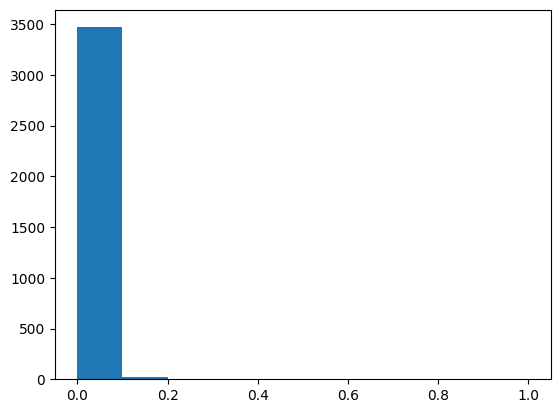

In [68]:
# CREATE REGRESSION XGBOOST MODEL FOR PLAYER SKILL PROBABILITIES DATASET 
# 1. Change all numeric columns with MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
columns_minmax_scaler = player_skills_column_included + player_attribute_column_included + ["statistic_success_total"]
# Store Description for all Numeric Columns in External CSV
df_description_numeric = xpass_player_skill_probs_df[columns_minmax_scaler].describe()
filename = 'xpass_skill_probs_description_numeric_data.csv'
directory_model = "data/model_xpass/"
df_description_numeric.to_csv(directory_model + filename)
# Preprocess to minmax scaler
xpass_player_skill_probs_df[columns_minmax_scaler] = scaler.fit_transform(xpass_player_skill_probs_df[columns_minmax_scaler])

# 2. Change type of minmax column as float64
xpass_player_skill_probs_df[columns_minmax_scaler] = xpass_player_skill_probs_df[columns_minmax_scaler].astype('float64')

# 3. Split train data and test data from Big Datasets
all_feature_columns = player_skills_column_included + player_attribute_column_included
X_train = xpass_player_skill_probs_df[all_feature_columns]
Y_train = xpass_player_skill_probs_df["statistic_success_total"]

# Empty dataframe for saving test result
empty_test_result = pd.DataFrame(columns=COLUMNS_EXPERIMENT_RESULT_PLAYER_SKILL_PROBS, index=[0])

for case_number in sorted(list(CONFIG_EXPERIMENTS_SKILL_PROBS_SCENARIO_MAP.keys())):
    feature_selection_opt = CONFIG_EXPERIMENTS_SKILL_PROBS_SCENARIO_MAP[case_number]["feature_selection_opt"]
    random_state_opt = CONFIG_EXPERIMENTS_SKILL_PROBS_SCENARIO_MAP[case_number]["random_state_opt"]

    # 4. Do feature selection on train data
    num_of_features = 10
    X_feature_sel, Y_feature_sel = globals()["training_data_feature_selection_reg_" + feature_selection_opt](X_train, Y_train, player_skills_column_included, num_of_features)

    # # 5. Do train_test_split on training data
    # X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_feature_sel, Y_feature_sel, test_size=0.2, random_state=random_state_opt)

    # 6. Train Model with XGBRegressor
    model = fit_and_train_with_model_xgbregressor(X_feature_sel, Y_feature_sel)

    # # 7. Predict Testing Data
    # y_predict = model.predict(X_test_split)

    # # 8. Save test result experiment
    # mean_squared_error_score = mean_squared_error(y_test_split, y_predict)
    # root_mean_squared_error_score = mean_squared_error(y_test_split, y_predict, squared=False)
    # mean_absolute_error_score = mean_absolute_error(y_test_split, y_predict)
    # r_squared_score = r2_score(y_test_split, y_predict)
    # mean_absolute_percentage_error_score = mean_absolute_percentage_error(y_test_split, y_predict)

    maps_new_row = {}
    eval_metrics_column = COLUMNS_EVALUATION_METRIC_REGRESSION
    for column in COLUMNS_EXPERIMENT_RESULT_PLAYER_SKILL_PROBS:
        if column not in eval_metrics_column:
            if column == "feature_selection_opt":
                maps_new_row["feature_selection_opt"] = feature_selection_opt
            elif column == "random_state_opt":
                maps_new_row["random_state_opt"] = random_state_opt
            elif column == "case_number":
                maps_new_row["case_number"] = case_number
        else:
            maps_new_row[column] = globals()[column]     
    new_row = pd.DataFrame(maps_new_row, index=[0])
    empty_test_result = pd.concat([new_row, empty_test_result.loc[:]]).reset_index(drop=True)

    # 9. Save model to external file
    filename = f'xpass_player_skill_probs_model_case_{case_number}.sav'
    directory_model = "data/model_xpass/"
    pickle.dump(model, open(directory_model + filename, 'wb'))

    case_number += 1

# 10. Save test result experiment to external file
filename = 'xpass_player_skill_probs_model_experiment_result.csv'
directory_model = "data/model_xpass/"
empty_test_result.to_csv(directory_model + filename)

In [59]:
# # CALCULATE REAL ACCURACY OF SUCCESSFUL PASSES BASED ON THRESHOLD
# CASE_NUMBER_LIST_FOR_AVAILABLE_XPASS_MODEL = [1, 2, 3, 4, 5, 6]
# CASE_NUMBER_LIST_FOR_AVAILABLE_XPASS_SKILL_PROBS_MODEL = [1, 2]
# DEFINED_THRESHOLD = 0.5
# MAPS_ACCURACY_SCORE_XPASS_MODEL = {}
# MAPS_XPASS_DIFFICULTY_VALUES_BY_ORIGINAL_EVENT_ID = {}
# MAPS_XPASS_SKILL_PROBS_VALUES_BY_PLAYER_ID = {}
# COLUMNS_XPASS_FINAL_ACCURACY_RESULT = [
#     "case_number_xpass_model",
#     "case_number_xpass_skill_probs_model",
#     "accuracy_without_skill",
#     "accuracy_with_player_skill",
#     "accuracy_difference"
# ]
# DIRECTORY_MODEL = "data/model_xpass/"

# # Construct maps xpass difficulty values and maps accuracy score xpass model
# for case_number_xpass_model in CASE_NUMBER_LIST_FOR_AVAILABLE_XPASS_MODEL:
#     # Loads xpass difficulty model
#     filename_xpass_model = f'xpass_model_case_{case_number_xpass_model}.sav'
#     xpass_model = pickle.load(open(DIRECTORY_MODEL + filename_xpass_model, 'rb'))
#     feature_names_xpass_model = xpass_model.get_booster().feature_names

#     actual_result_ids = pd.Series(big_dataframe_xpass_model_test["result_id"]).tolist()
#     original_event_ids = pd.Series(big_dataframe_xpass_model_test["original_event_id"]).tolist()
#     player_ids = pd.Series(big_dataframe_xpass_model_test["player_id"]).tolist()
#     xpass_train_data = big_dataframe_xpass_model_test[feature_names_xpass_model]
#     xpass_difficulty_value = [p[1] for p in xpass_model.predict_proba(xpass_train_data)]
    
#     number_correct_prediction = 0
#     number_total_valid_data = 0
#     for idx, event_id in enumerate(original_event_ids):
#         actual_result_id = actual_result_ids[idx]
#         xpass_difficulty_this_value = xpass_difficulty_value[idx]
#         player_id = player_ids[idx]
#         player_data = xpass_player_skill_probs_df[xpass_player_skill_probs_df["player_id"] == player_id]
#         if (not player_data.empty):
#             MAPS_XPASS_DIFFICULTY_VALUES_BY_ORIGINAL_EVENT_ID[(case_number_xpass_model, event_id)] = xpass_difficulty_this_value
#             predicted_result_id = 1 if xpass_difficulty_this_value > DEFINED_THRESHOLD else 0
#             if (actual_result_id == predicted_result_id):
#                 number_correct_prediction += 1
#             number_total_valid_data += 1
#     MAPS_ACCURACY_SCORE_XPASS_MODEL[case_number_xpass_model] = number_correct_prediction / number_total_valid_data

# # Construct maps xpass player skill probabilities value
# unique_player_ids = list(set(pd.Series(big_dataframe_xpass_model_test["player_id"]).tolist()))
# for case_number_xpass_skill_probs_model in CASE_NUMBER_LIST_FOR_AVAILABLE_XPASS_SKILL_PROBS_MODEL:
#     # Load xpass player skill probs model
#     filename_xpass_skill_probs_model = f'xpass_player_skill_probs_model_case_{case_number_xpass_skill_probs_model}.sav'
#     xpass_skill_probs_model = pickle.load(open(DIRECTORY_MODEL + filename_xpass_skill_probs_model, 'rb'))
#     feature_names_xpass_skill_probs_model = xpass_skill_probs_model.get_booster().feature_names

#     for player_id in unique_player_ids:
#         xpass_skill_train_data = xpass_player_skill_probs_df[xpass_player_skill_probs_df["player_id"] == player_id][feature_names_xpass_skill_probs_model]
#         if (not xpass_skill_train_data.empty):
#             xpass_skill_value = xpass_skill_probs_model.predict(xpass_skill_train_data)[0]
#             MAPS_XPASS_SKILL_PROBS_VALUES_BY_PLAYER_ID[(case_number_xpass_skill_probs_model, player_id)] = xpass_skill_value

# # Final Calculation and Saving Test Result
# empty_test_result = pd.DataFrame(columns=COLUMNS_XPASS_FINAL_ACCURACY_RESULT, index=[0])

# for case_number_xpass_model in CASE_NUMBER_LIST_FOR_AVAILABLE_XPASS_MODEL:
#     for case_number_xpass_skill_probs_model in CASE_NUMBER_LIST_FOR_AVAILABLE_XPASS_SKILL_PROBS_MODEL:
#         number_correct_prediction = 0
#         number_total_valid_data = 0
#         for _, xpass_row_data in big_dataframe_xpass_model_test.iterrows():
#             actual_result_id = xpass_row_data["result_id"]
#             original_event_id = xpass_row_data["original_event_id"]
#             related_player_id = xpass_row_data["player_id"]
#             xpass_skill_train_data = xpass_player_skill_probs_df[xpass_player_skill_probs_df["player_id"] == related_player_id][feature_names_xpass_skill_probs_model]
#             if (not xpass_skill_train_data.empty):
#                 xpass_difficulty_value = MAPS_XPASS_DIFFICULTY_VALUES_BY_ORIGINAL_EVENT_ID[(case_number_xpass_model, original_event_id)]
#                 xpass_skill_value = MAPS_XPASS_SKILL_PROBS_VALUES_BY_PLAYER_ID[(case_number_xpass_skill_probs_model, related_player_id)]
#                 predicted_result_id = 1 if (xpass_difficulty_value * xpass_skill_value) > DEFINED_THRESHOLD else 0
#                 if (actual_result_id == predicted_result_id):
#                     number_correct_prediction += 1
#                 number_total_valid_data += 1

#         accuracy_with_player_skill = number_correct_prediction / number_total_valid_data
#         accuracy_without_player_skill = MAPS_ACCURACY_SCORE_XPASS_MODEL[case_number_xpass_model]
#         maps_new_row = {
#             "case_number_xpass_model" : case_number_xpass_model,
#             "case_number_xpass_skill_probs_model" : case_number_xpass_skill_probs_model,
#             "accuracy_without_skill" : accuracy_without_player_skill,
#             "accuracy_with_player_skill" : accuracy_with_player_skill,
#             "accuracy_difference" : (accuracy_without_player_skill - accuracy_with_player_skill)
#         }
#         new_row = pd.DataFrame(maps_new_row, index=[0])
#         empty_test_result = pd.concat([new_row, empty_test_result.loc[:]]).reset_index(drop=True)
        
# filename_experiment_result = f'xpass_final_accuracy_with_threshold_{DEFINED_THRESHOLD}.csv'
# empty_test_result.to_csv(DIRECTORY_MODEL + filename_experiment_result)

In [60]:
# MAPS_CASE_NUMBER_MODEL = {
#     "best" : {
#         "case_number_xpass_model" : 5,
#         "case_number_xpass_skill_probs_model" : 2
#     },
#     "worst" : {
#         "case_number_xpass_model" : 3,
#         "case_number_xpass_skill_probs_model" : 1
#     }
# }
# MAPS_COMPETITIONS_AND_EVENT_ID_DIRECTORY = {
#     (55, 43) : {
#         "competition_name" : "UEFA Euro 2020"
#     },
#     (43, 106) : {
#         "competition_name" : "FIFA World Cup 2022"
#     }
# }
# DIRECTORY_MODEL = "data/model_xpass/"

# # Helper Functions
# def calculate_minmaxscaler_value(row, column_name, min_value, max_value):
#     return ((row[column_name] - min_value) / (max_value - min_value))

# def convert_all_numeric_columns_with_min_max_scaler(df_data, column_names, df_description_numeric):
#     for column_name in column_names:
#         min_value_this_column = df_description_numeric[column_name]["min"]
#         max_value_this_column = df_description_numeric[column_name]["max"]
#         df_data[column_name] = df_data.apply(lambda x : calculate_minmaxscaler_value(x, column_name, min_value_this_column, max_value_this_column), axis=1)
#     return df_data

# def preprocess_player_skill_probs_df(player_skill_probs_df):
#     # 1. Change all numeric columns with MinMaxScaler
#     columns_minmax_scaler = player_attribute_column_included + player_skills_column_included
#     # Load Description for all Numeric Columns from External CSV
#     filename = 'xpass_skill_probs_description_numeric_data.csv'
#     df_description_numeric = pd.read_csv(DIRECTORY_MODEL + filename, index_col=0)
#     # Preprocess to minmax scaler
#     player_skill_probs_df = convert_all_numeric_columns_with_min_max_scaler(player_skill_probs_df, columns_minmax_scaler, df_description_numeric)

#     return player_skill_probs_df

# # Preprocessed for xpass difficulty dataset
# scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
# columns_minmax_scaler = player_skills_column_included + player_attribute_column_included + \
#                         ["start_x", "start_y", "end_x", "end_y", "distance_pass", "distance_sideline", 
#                         "distance_goal", "distance_receiver_sideline", "distance_receiver_goal", "angle_pass",
#                         "distance_opponent", "num_opponent_closer_goal", "distance_receiver_opponent", 
#                         "num_opponent_closer_goal_receiver", "num_opponent_in_path", "num_opponent_in_path_receiver"]
# big_dataframe_xpass_model[columns_minmax_scaler] = scaler.fit_transform(big_dataframe_xpass_model[columns_minmax_scaler])
# big_dataframe_xpass_model = big_dataframe_xpass_model[big_dataframe_xpass_model['result_id'].isin([0,1])]

# # # Preprocessed for xpass player skill probs dataset
# # scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
# # columns_minmax_scaler = player_skills_column_included + player_attribute_column_included + ["statistic_success_action_probs"]
# # xpass_player_skill_probs_df[columns_minmax_scaler] = scaler.fit_transform(xpass_player_skill_probs_df[columns_minmax_scaler])

# # Calculate ratings for each players for passing

# for competition_id, season_id in list(MAPS_COMPETITIONS_AND_EVENT_ID_DIRECTORY.keys()):
#     competition_name = MAPS_COMPETITIONS_AND_EVENT_ID_DIRECTORY[(competition_id, season_id)]["competition_name"]
#     filename_maps_competition_and_event_ids = f'xpass_map_competition_and_event_id_for_{competition_name}.csv'
#     maps_competition_and_event_ids_df = pd.read_csv(DIRECTORY_MODEL + filename_maps_competition_and_event_ids)
#     list_related_event_ids_this_competition = pd.Series(maps_competition_and_event_ids_df['event_id_related']).tolist()
    
#     filename_vaep_ranking_this_competition = f'vaep_players_ranking_for_competition_{competition_name}.csv'
#     directory_vaep_ranking = "data/players_skill_dataset/"
#     vaep_ranking_df_this_competition = pd.read_csv(directory_vaep_ranking + filename_vaep_ranking_this_competition)

#     for scenario in list(MAPS_CASE_NUMBER_MODEL.keys()):
#         case_number_xpass_model = MAPS_CASE_NUMBER_MODEL[scenario]["case_number_xpass_model"]
#         case_number_xpass_skill_model = MAPS_CASE_NUMBER_MODEL[scenario]["case_number_xpass_skill_probs_model"]
#         empty_df_result = pd.DataFrame(columns=player_skills_column_included + player_attribute_column_included + ['statistic_pass_contribution'], index=[0])

#         for _, row_player in vaep_ranking_df_this_competition.iterrows():
#             player_id = row_player['player_id']
#             maps_event_id_with_difficulty_value = {}
#             related_events_with_this_player = big_dataframe_xpass_model \
#                     [(big_dataframe_xpass_model['original_event_id'].isin(list_related_event_ids_this_competition)) & 
#                     (big_dataframe_xpass_model['player_id'] == player_id)]
#             event_ids_list_for_this_player = pd.Series(related_events_with_this_player['original_event_id']).tolist()
            
#             # Give score for difficulty
#             filename_xpass_model = f'xpass_model_case_{case_number_xpass_model}.sav'
#             xpass_model = pickle.load(open(DIRECTORY_MODEL + filename_xpass_model, 'rb'))
#             feature_names_xpass_model = xpass_model.get_booster().feature_names
#             if (not related_events_with_this_player.empty):
#                 train_data = related_events_with_this_player[feature_names_xpass_model]
#                 xpass_difficulty_value = [p[1] for p in xpass_model.predict_proba(train_data)]
#                 for idx, event_id in enumerate(event_ids_list_for_this_player):
#                     maps_event_id_with_difficulty_value[event_id] = 1 - xpass_difficulty_value[idx]
            
#             # Give score for player skill
#             filename_xpass_skill_probs_model = f'xpass_player_skill_probs_model_case_{case_number_xpass_skill_model}.sav'
#             xpass_skill_probs_model = pickle.load(open(DIRECTORY_MODEL + filename_xpass_skill_probs_model, 'rb'))
#             feature_names_xpass_skill_probs_model = xpass_skill_probs_model.get_booster().feature_names
#             train_data = pd.DataFrame(columns=player_skills_column_included + player_attribute_column_included, index=[0])
#             row_train_data = {}
#             for skill in player_skills_column_included:
#                 row_train_data[skill] = row_player[skill]
#             for attribute in player_attribute_column_included:
#                 row_train_data[attribute] = row_player[attribute]
#             row_train_data = pd.DataFrame(row_train_data, index=[0])
#             train_data = pd.concat([row_train_data, train_data.loc[:]]).reset_index(drop=True)
#             train_data.dropna(inplace=True)
#             train_data = preprocess_player_skill_probs_df(train_data)
#             train_data = train_data[feature_names_xpass_skill_probs_model]
#             xpass_skill_value = xpass_skill_probs_model.predict(train_data)[0]

#             # Calculate final player contribution for this competition
#             total_score_this_player = 0
#             if (not related_events_with_this_player.empty):
#                 for _, row_event in related_events_with_this_player.iterrows():
#                     total_score_this_player += row_event['result_id'] * maps_event_id_with_difficulty_value[row_event['original_event_id']] * xpass_skill_value
#             row_statistic_result = {}
#             row_statistic_result['player_id'] = row_player['player_id']
#             row_statistic_result['full_name'] = row_player['full_name']
#             for skill in player_skills_column_included:
#                 row_statistic_result[skill] = row_player[skill]
#             for attribute in player_attribute_column_included:
#                 row_statistic_result[attribute] = row_player[attribute]
#             row_statistic_result['statistic_pass_contribution'] = total_score_this_player
#             row_statistic_result = pd.DataFrame(row_statistic_result, index=[0])
#             empty_df_result = pd.concat([row_statistic_result, empty_df_result.loc[:]]).reset_index(drop=True)

#         filename_player_score_result = f'xpass_contribution_score_player_{scenario}_scenario_{competition_name}.csv'
#         empty_df_result.to_csv(DIRECTORY_MODEL + filename_player_score_result)
        